# Clasificador de animales
## Diego Maldonado Castro

### Importamos librerías

In [1]:
import random
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import torch.nn.functional as F


A falta de soporte de fast.ai para Mac vamos a declarar la clase para nuestros datos.

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        self.label_mapping = {label: idx for idx, label in enumerate(self.annotations['Animal'].unique())}


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0]  # nombre de img.
        img_path = os.path.join(self.root_dir, img_name)  # unir nombres de img.
        
        image = Image.open(img_path).convert('RGB')

        label = self.annotations.iloc[idx, 1]  # etiquetas

        label = self.label_mapping.get(label, -1)

        image = self.transform(image) if self.transform else transforms.ToTensor()(image)
        label = torch.tensor(label)  # label a tensor

        return image, label


Aplicamos una transformación simple a las imágenes y cargamos nuestros datos

In [17]:
# transformaciones
transform = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

csv_file = './AnimalsSmall/train.csv'  # CSV 
root_dir = './AnimalsSmall/images'     # img. 

custom_dataset = CustomImageDataset(csv_file=csv_file, root_dir=root_dir, transform=transform);len(custom_dataset) #number of img

13000

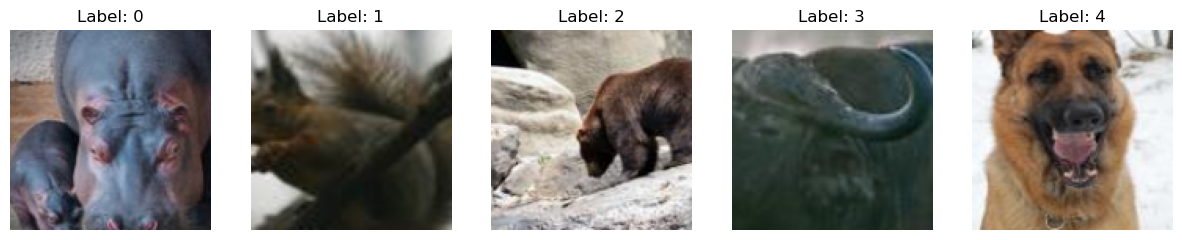

In [18]:
import matplotlib.pyplot as plt

# Plot the first 5 images with normalization applied
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    image, label = custom_dataset[i]
    
    # Permute to (H, W, C) for visualization
    image = image.permute(1, 2, 0)
    
    axes[i].imshow(image.numpy())  # Show the image directly with normalization
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.show()


In [5]:
image, label = custom_dataset[5] #Checando el tamaño de los tensores
print(image.shape,label)

torch.Size([3, 256, 256]) tensor(5)


Declaramos el modelo

In [19]:
model = nn.Sequential(
    nn.BatchNorm2d(3),
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(256, 30), # 30 clases de animales
)


In [20]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-5) # Optimizador Adam

In [21]:
num_epochs = 20 
device = torch.device('mps') # para Mac se usa mps
model.to(device)

Sequential(
  (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (9): ReLU()
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (12): AdaptiveAvgPool2d(output_size=1)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=256, out_features=30, bias=True)
)

In [22]:
dataset_size = len(custom_dataset)

In [23]:
random.seed(42)

Creando el conjunto de entrenamiento, validación y entrenamos el modelo

In [ ]:
train_subset_size = int(0.8 * dataset_size)  
eval_subset_size = dataset_size - train_subset_size

indices = list(range(dataset_size))
random.shuffle(indices)

train_indices = indices[:train_subset_size]
eval_indices = indices[train_subset_size:]

train_subset = Subset(custom_dataset, train_indices)
eval_subset = Subset(custom_dataset, eval_indices)

train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
eval_loader = DataLoader(eval_subset, batch_size=13, shuffle=False)



for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    # Evaluacion
    model.eval()
    eval_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    eval_loss /= len(eval_loader.dataset)
    eval_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy:.2f}%")

print("Training complete.")


Epoch 1/20, Training Loss: 3.0616
Epoch 1/20, Evaluation Loss: 2.8998, Evaluation Accuracy: 19.15%
Epoch 2/20, Training Loss: 2.8129
Epoch 2/20, Evaluation Loss: 2.7755, Evaluation Accuracy: 21.54%


In [1]:
import pandas as pd

# Load the CSV file
csv_file = './AnimalsSmall/train.csv'
data = pd.read_csv(csv_file)

# Assuming the label column is 'Animal'
labels = data['Animal'].unique()  # Get unique labels
num_labels = len(labels)  # Get number of unique labels

print(f"Number of unique labels: {num_labels}")
print(f"Labels: {labels}")


Number of unique labels: 30
Labels: ['hippopotamus' 'squirrel' 'grizzly+bear' 'ox' 'german+shepherd' 'buffalo'
 'otter' 'bobcat' 'wolf' 'persian+cat' 'collie' 'antelope' 'seal'
 'dalmatian' 'siamese+cat' 'moose' 'horse' 'killer+whale' 'mouse' 'walrus'
 'beaver' 'rhinoceros' 'chimpanzee' 'weasel' 'spider+monkey' 'raccoon'
 'rat' 'chihuahua' 'mole' 'bat']
